In [48]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
#from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter
import scipy.stats as stat
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

# Seeting seaborn style
sns.set()

Collect initial data

In [6]:
#import file csv
df = pd.read_csv('retail.csv')
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Describe, explore and assess data quality

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df.replace("", np.nan, inplace=True)

In [11]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#FUNCTION TO SHOW MISSING VALUES AND THEIR PERCENTAGES
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

In [13]:
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,135080,24.926694
2,Description,1454,0.268311


In [14]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [15]:
df1 = df.copy()

## Data Preparation:

### Clean data

In [16]:
# Droping duplicated rows
df1.drop_duplicates(inplace=True)

In [17]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [23]:
# Droping irelevant columns
#df1['StockCode'].drop(['POST'], axis=0, inplace=True)
df1= df1[~  df1['StockCode'].isin(['DCGS0076','DCGS0003',
'DCGS0070',
'DCGS0055', 
'DCGS0072', 
'DCGS0074', 
'DCGS0069', 
'DCGS0057', 
'DCGSSBOY', 
'DCGSSGIRL', 
'DCGS0004', 
'DCGS0073', 
'DCGS0071', 
'DCGS0068', 
'DCGS0067', 
'DCGS0066P', 
'POST', 
'D', 
'DOT', 
'M', 
'BANK CHARGES', 
'S', 
'AMAZONFEE', 
'gift_0001_40', 
'gift_0001_50', 
'gift_0001_30', 
'gift_0001_20', 
'gift_0001_10', 
'PADS', 
'B', 
'CRUK', 
'c2' 
])]


In [24]:
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.985


In [29]:
df1['Country'].value_counts()
#keep Unspecified because doesnt affect the collaborative filtering algorithm

United Kingdom          488664
Germany                   9081
France                    8220
EIRE                      8171
Spain                     2463
Netherlands               2330
Belgium                   1971
Switzerland               1961
Portugal                  1466
Australia                 1256
Norway                    1060
Italy                      783
Channel Islands            755
Finland                    653
Cyprus                     608
Unspecified                442
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     294
USA                        291
Hong Kong                  276
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

In [30]:
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,133974,25.098305
2,Description,1440,0.269765


In [55]:
# get max CustomerID
idMax = df1['CustomerID'].max()



# get distinct invoice numbers for records where CustomerID is null
invoicesNullCustomer = df1[df1['CustomerID'].isnull()]['InvoiceNo'].unique()



next_customerId = idMax+1
for invoiceNo in invoicesNullCustomer:
    df1.loc[df1['InvoiceNo'] == invoiceNo, 'CustomerID'] = next_customerId
    next_customerId +=1


In [58]:
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
2,Description,1440,0.269765


In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533797 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    533797 non-null  object 
 1   StockCode    533797 non-null  object 
 2   Description  532357 non-null  object 
 3   Quantity     533797 non-null  int64  
 4   InvoiceDate  533797 non-null  object 
 5   UnitPrice    533797 non-null  float64
 6   CustomerID   533797 non-null  float64
 7   Country      533797 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 56.7+ MB


In [82]:
df1['InvoiceDate'] = df1['InvoiceDate'].astype('datetime64[ns]')
df1['Month_Year'] = df1['InvoiceDate'].dt.strftime('%Y-%m')
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533797 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    533797 non-null  object        
 1   StockCode    533797 non-null  object        
 2   Description  532357 non-null  object        
 3   Quantity     533797 non-null  int64         
 4   InvoiceDate  533797 non-null  datetime64[ns]
 5   UnitPrice    533797 non-null  float64       
 6   CustomerID   533797 non-null  float64       
 7   Country      533797 non-null  object        
 8   Month_Year   533797 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 60.7+ MB


In [83]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualization/Correlations

C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\si

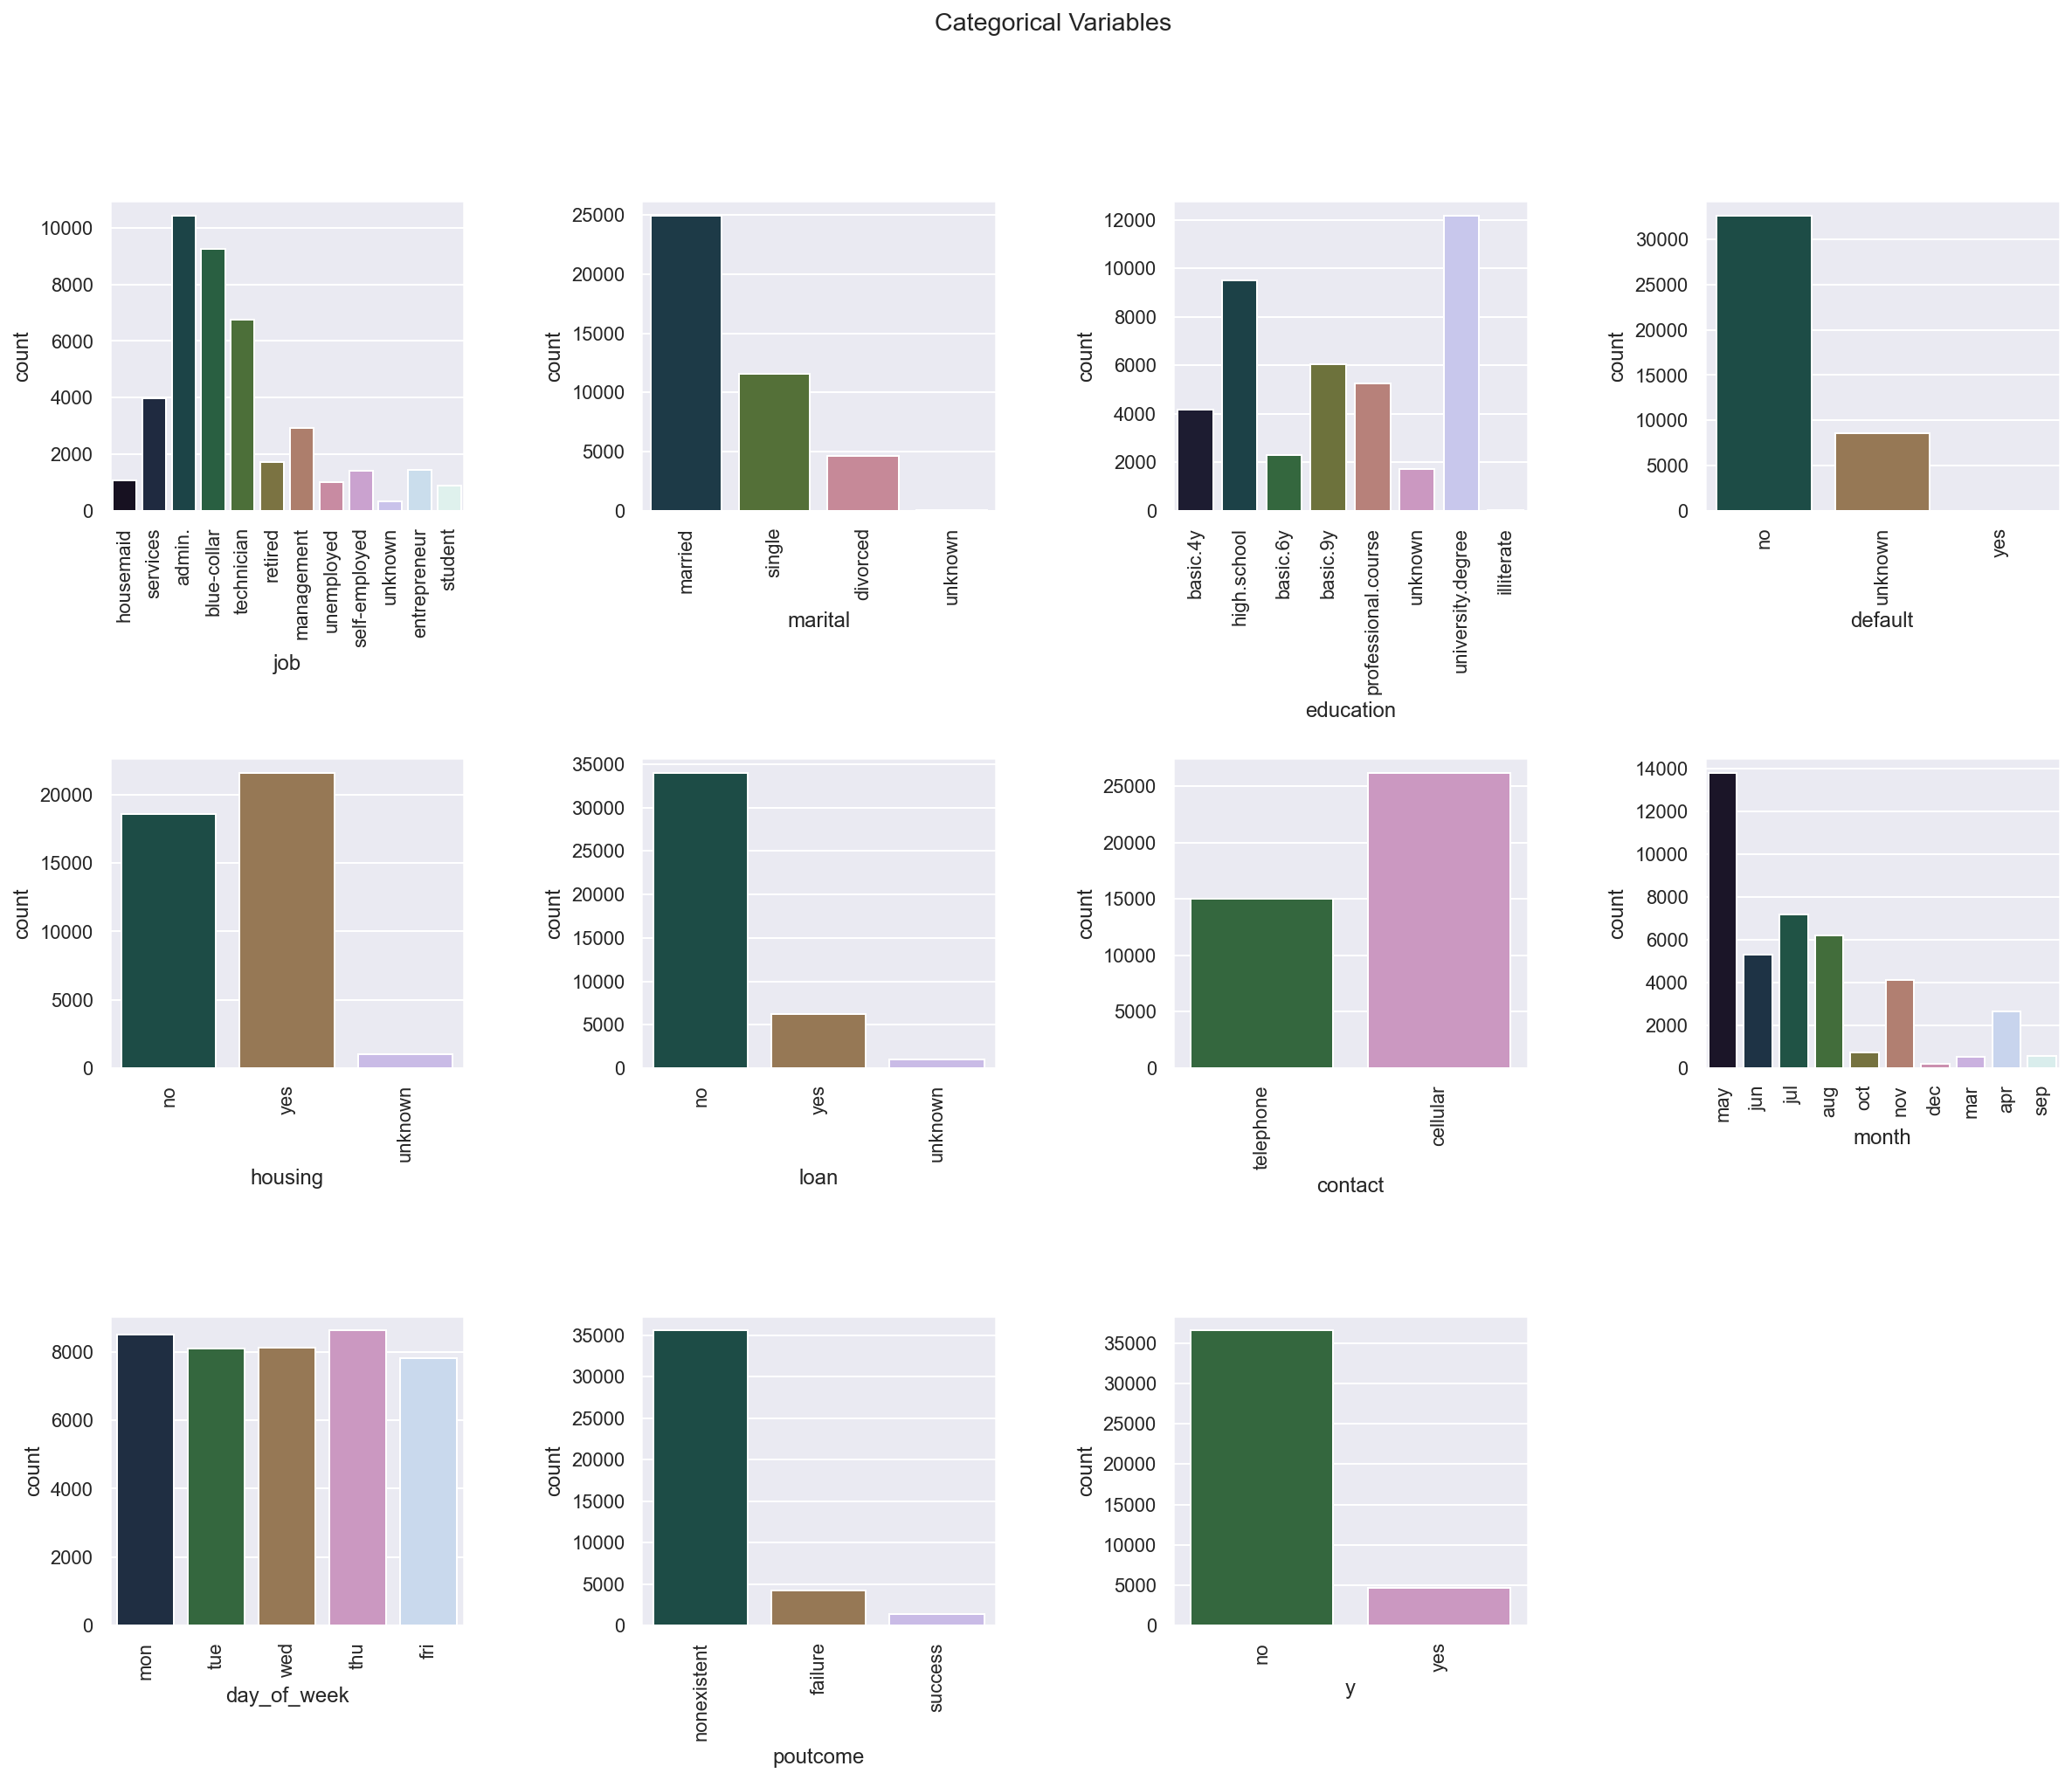

In [13]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(3, ceil(len(non_metric_features) / 3), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features):
    g = sns.countplot(df1[feat], ax=ax, palette = 'cubehelix')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

title = "Categorical Variables"
plt.suptitle(title)
plt.subplots_adjust(wspace=0.5, hspace=0.8)

#Remove the last graphic
axes.flatten()[-1].remove()

plt.show()

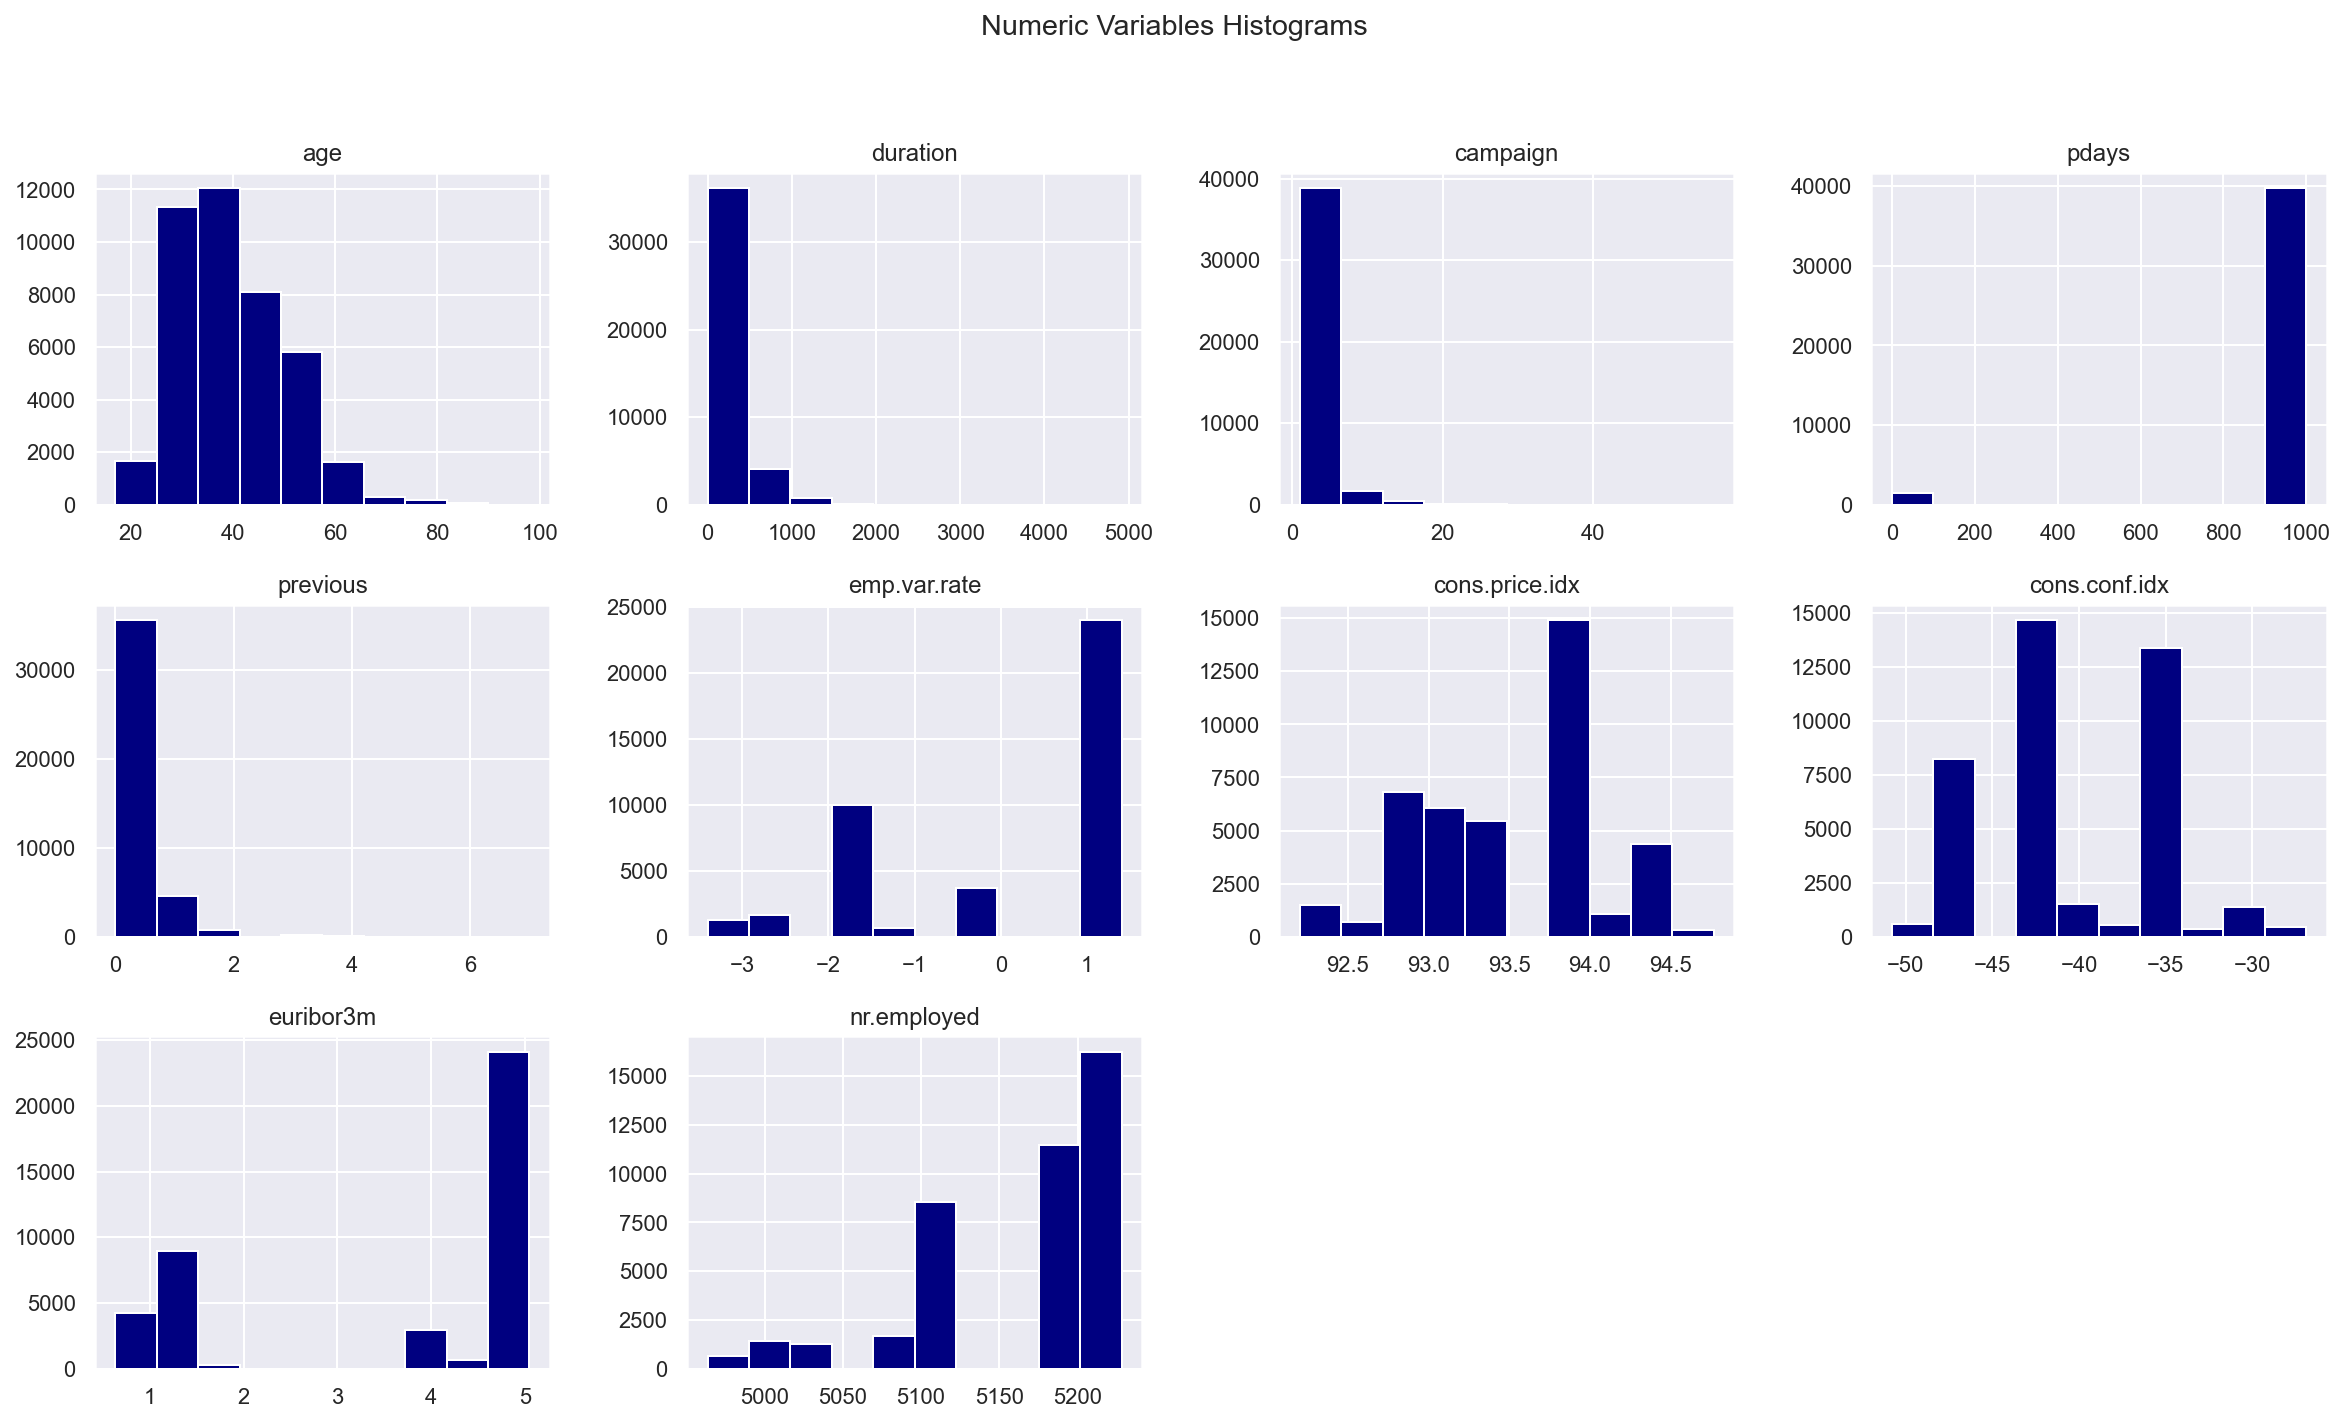

In [14]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(df1[feat], color = "Navy")
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Histograms"
plt.suptitle(title)
#Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Remove the last 2 graphics
axes.flatten()[-1].remove()
axes.flatten()[-2].remove()
plt.show()

C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\debor\anaconda3\lib\si

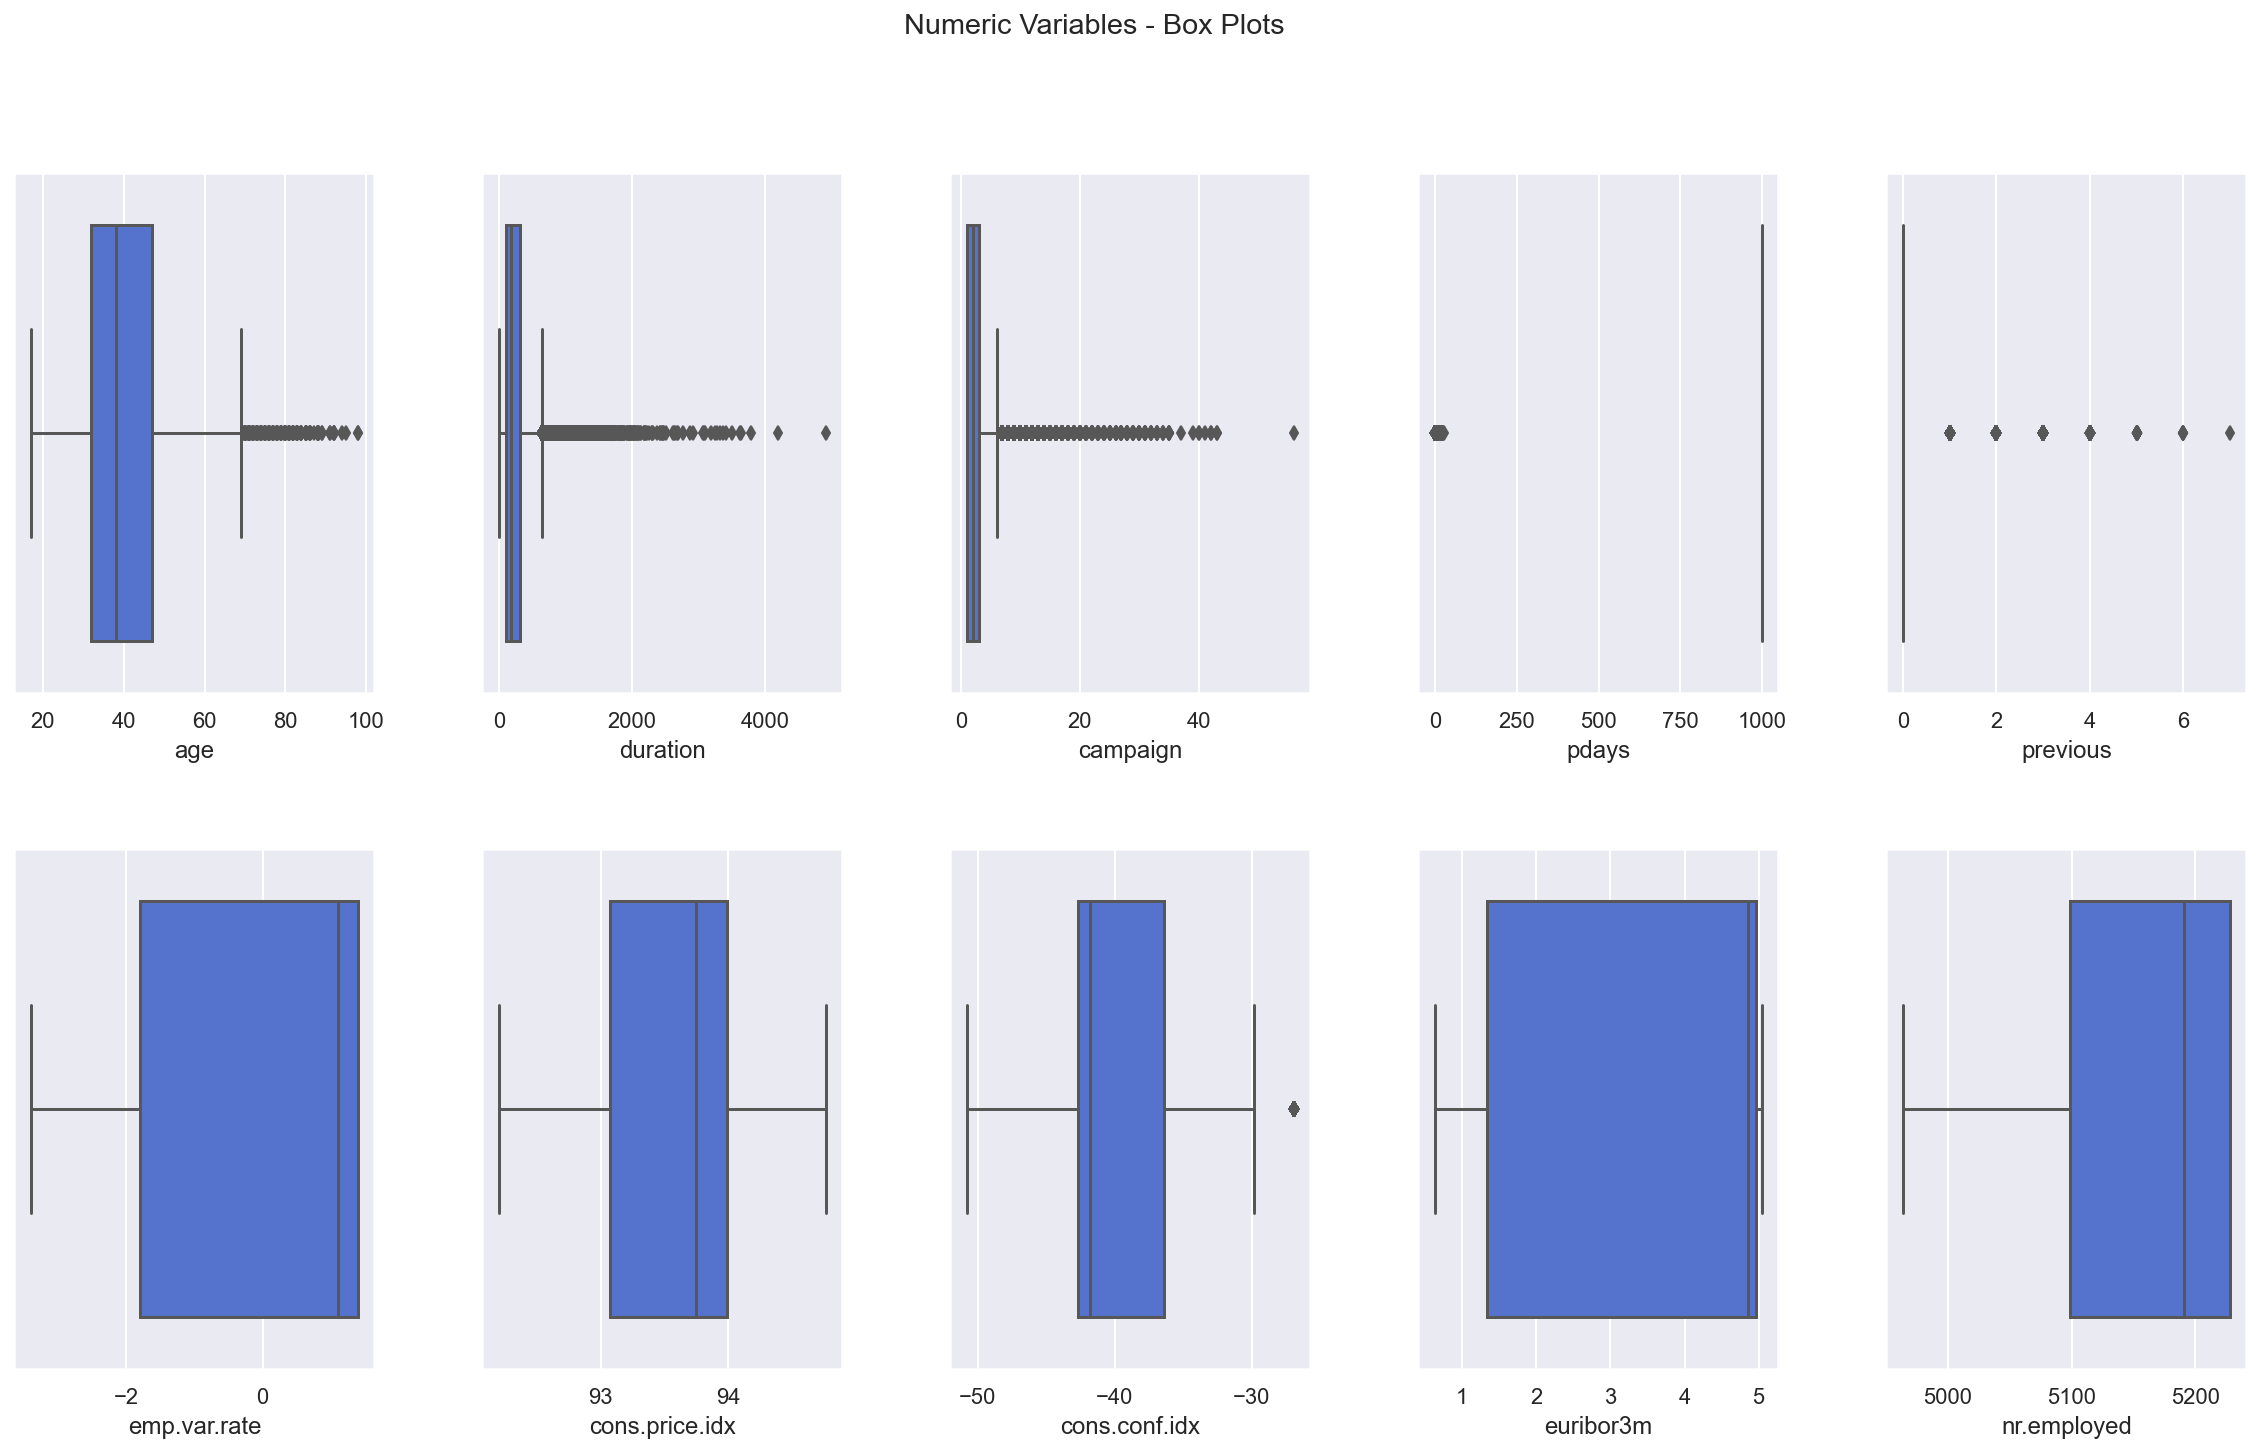

In [15]:
# All Numeric Variables Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(df1[feat], ax=ax,color="royalblue")
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables - Box Plots"

plt.suptitle(title)

#Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)


plt.show()

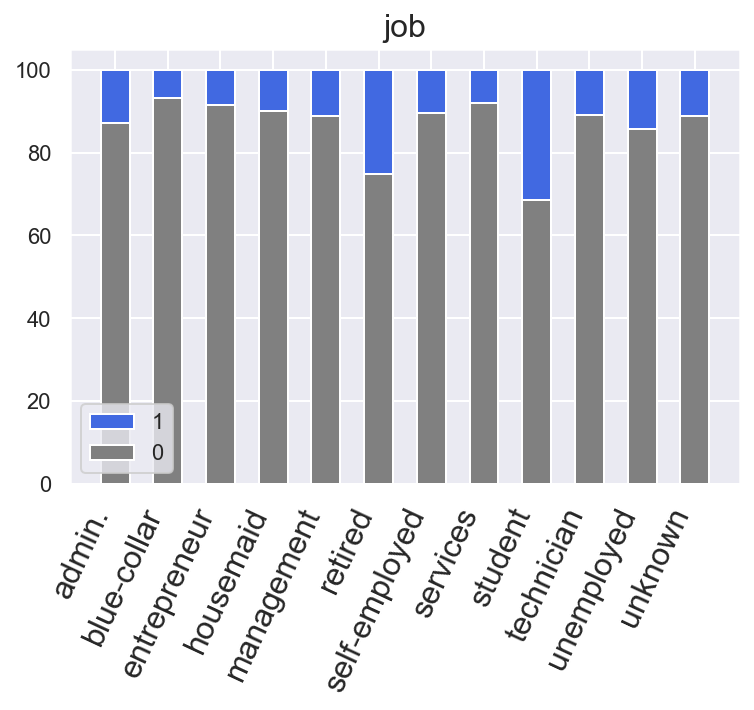

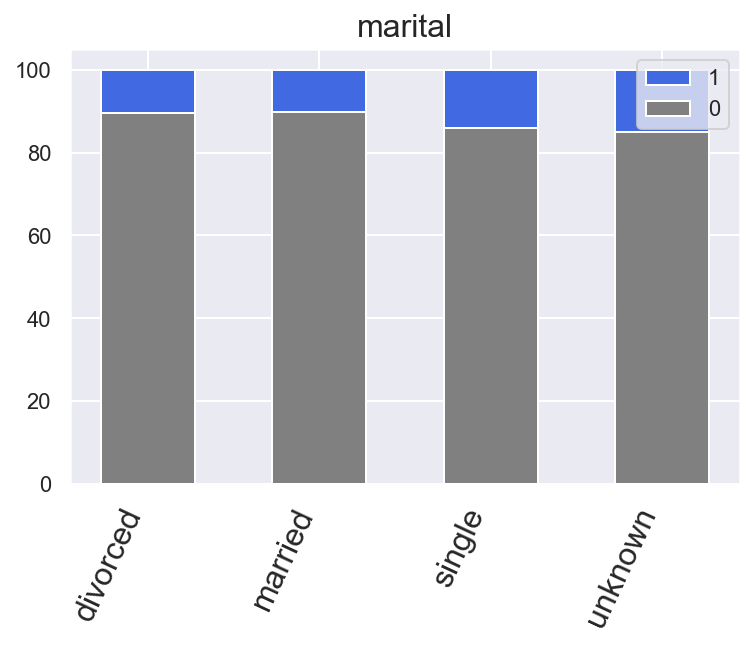

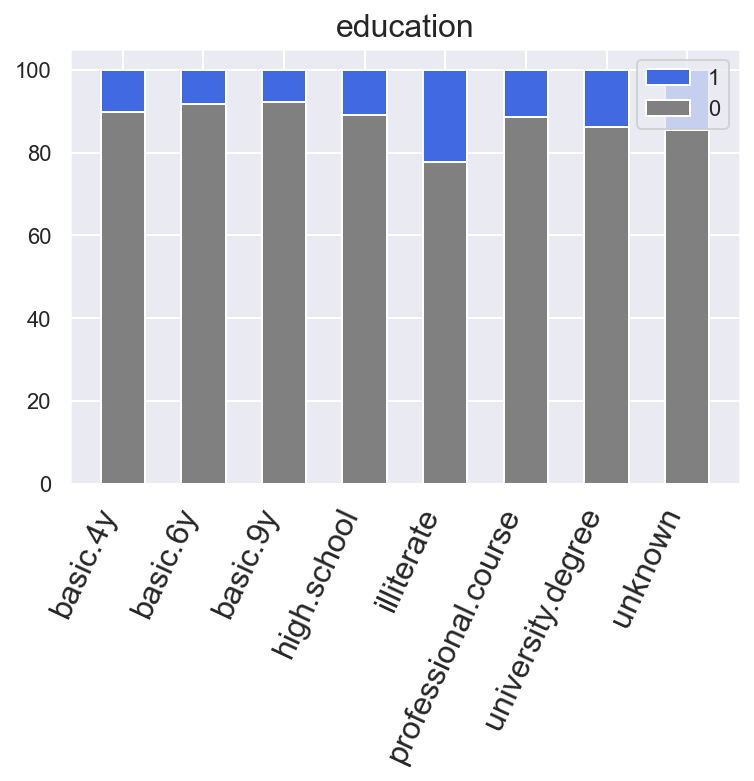

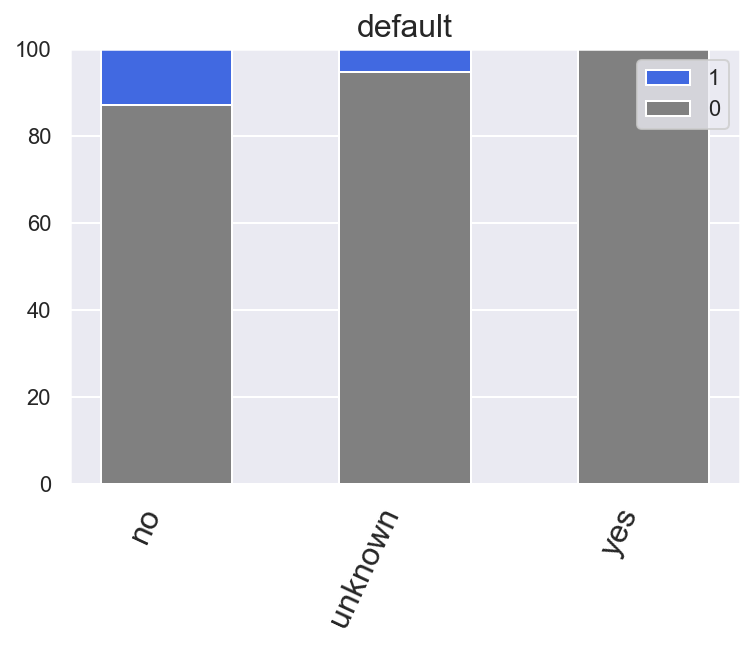

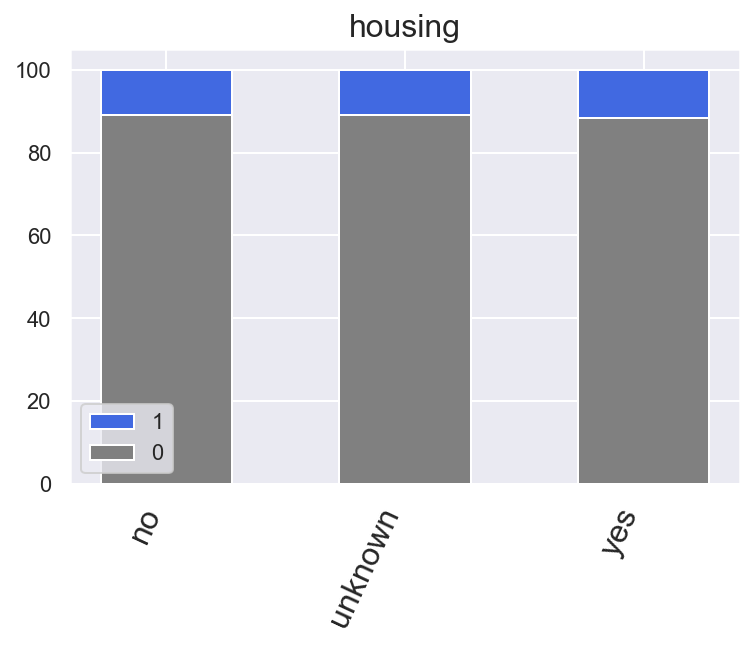

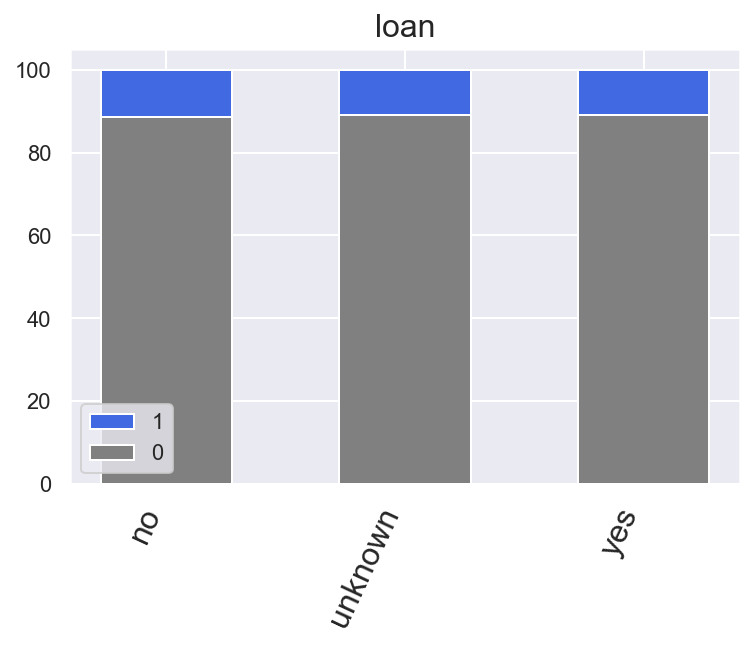

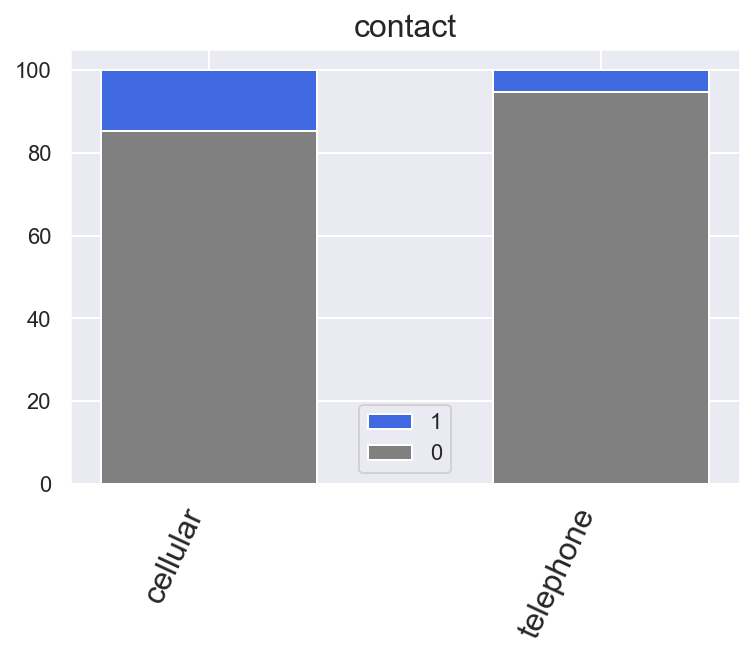

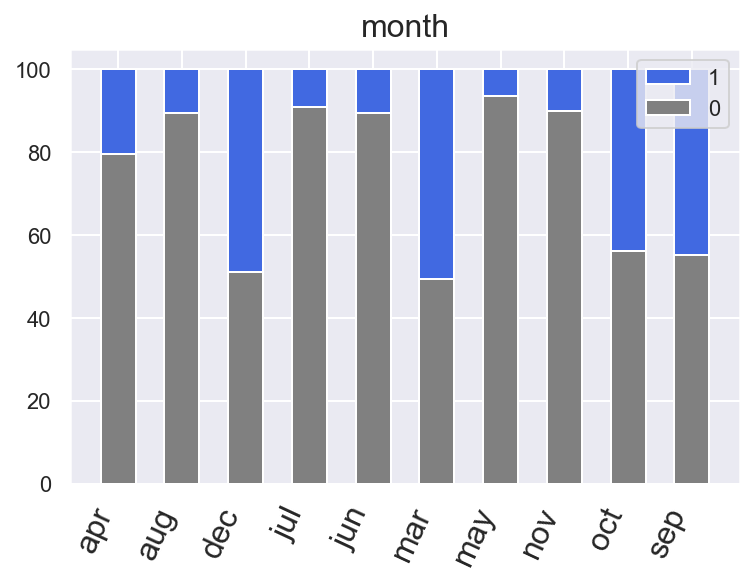

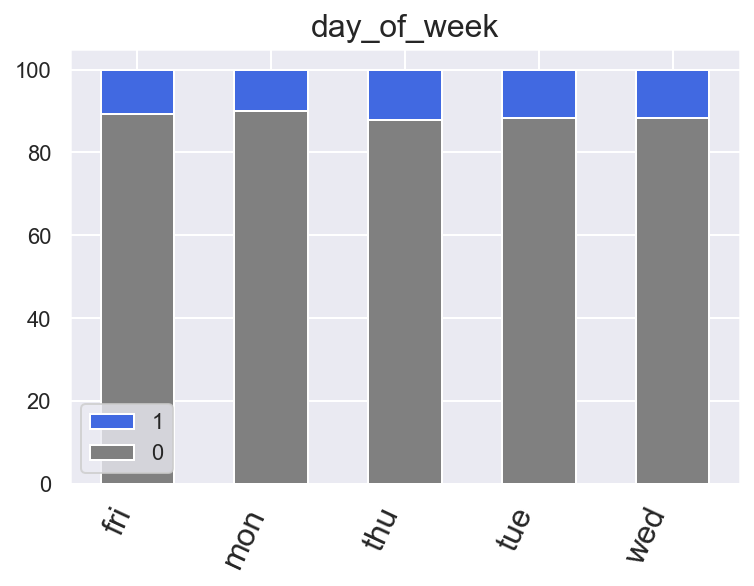

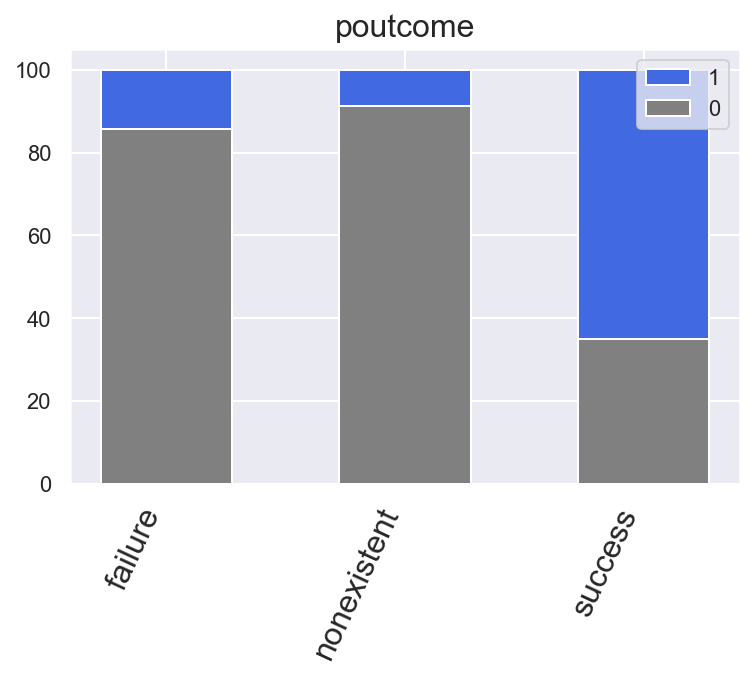

In [16]:
#Create visualizations separated by categorical target (ONLY WORK FOR CLASSIFICATION PROBLEMS -target values 0 or 1)
#Remove target value of non_metric_features
non_metric_features2 = non_metric_features.copy()
non_metric_features2.remove("y")

for feature in non_metric_features2:
    cont_tab = pd.crosstab(df1[feature], df1['y'], margins = True)
    categories = cont_tab.index[:-1]
    obs_pct = np.array([(np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values))*100, 
                        (np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values))*100])
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="royalblue")
    plt.legend((p2[0], p1[0]), ('1', '0'))
    plt.title(feature, size = 16)
    plt.xticks(rotation=65, size = 16,ha = 'right')
    plt.show()

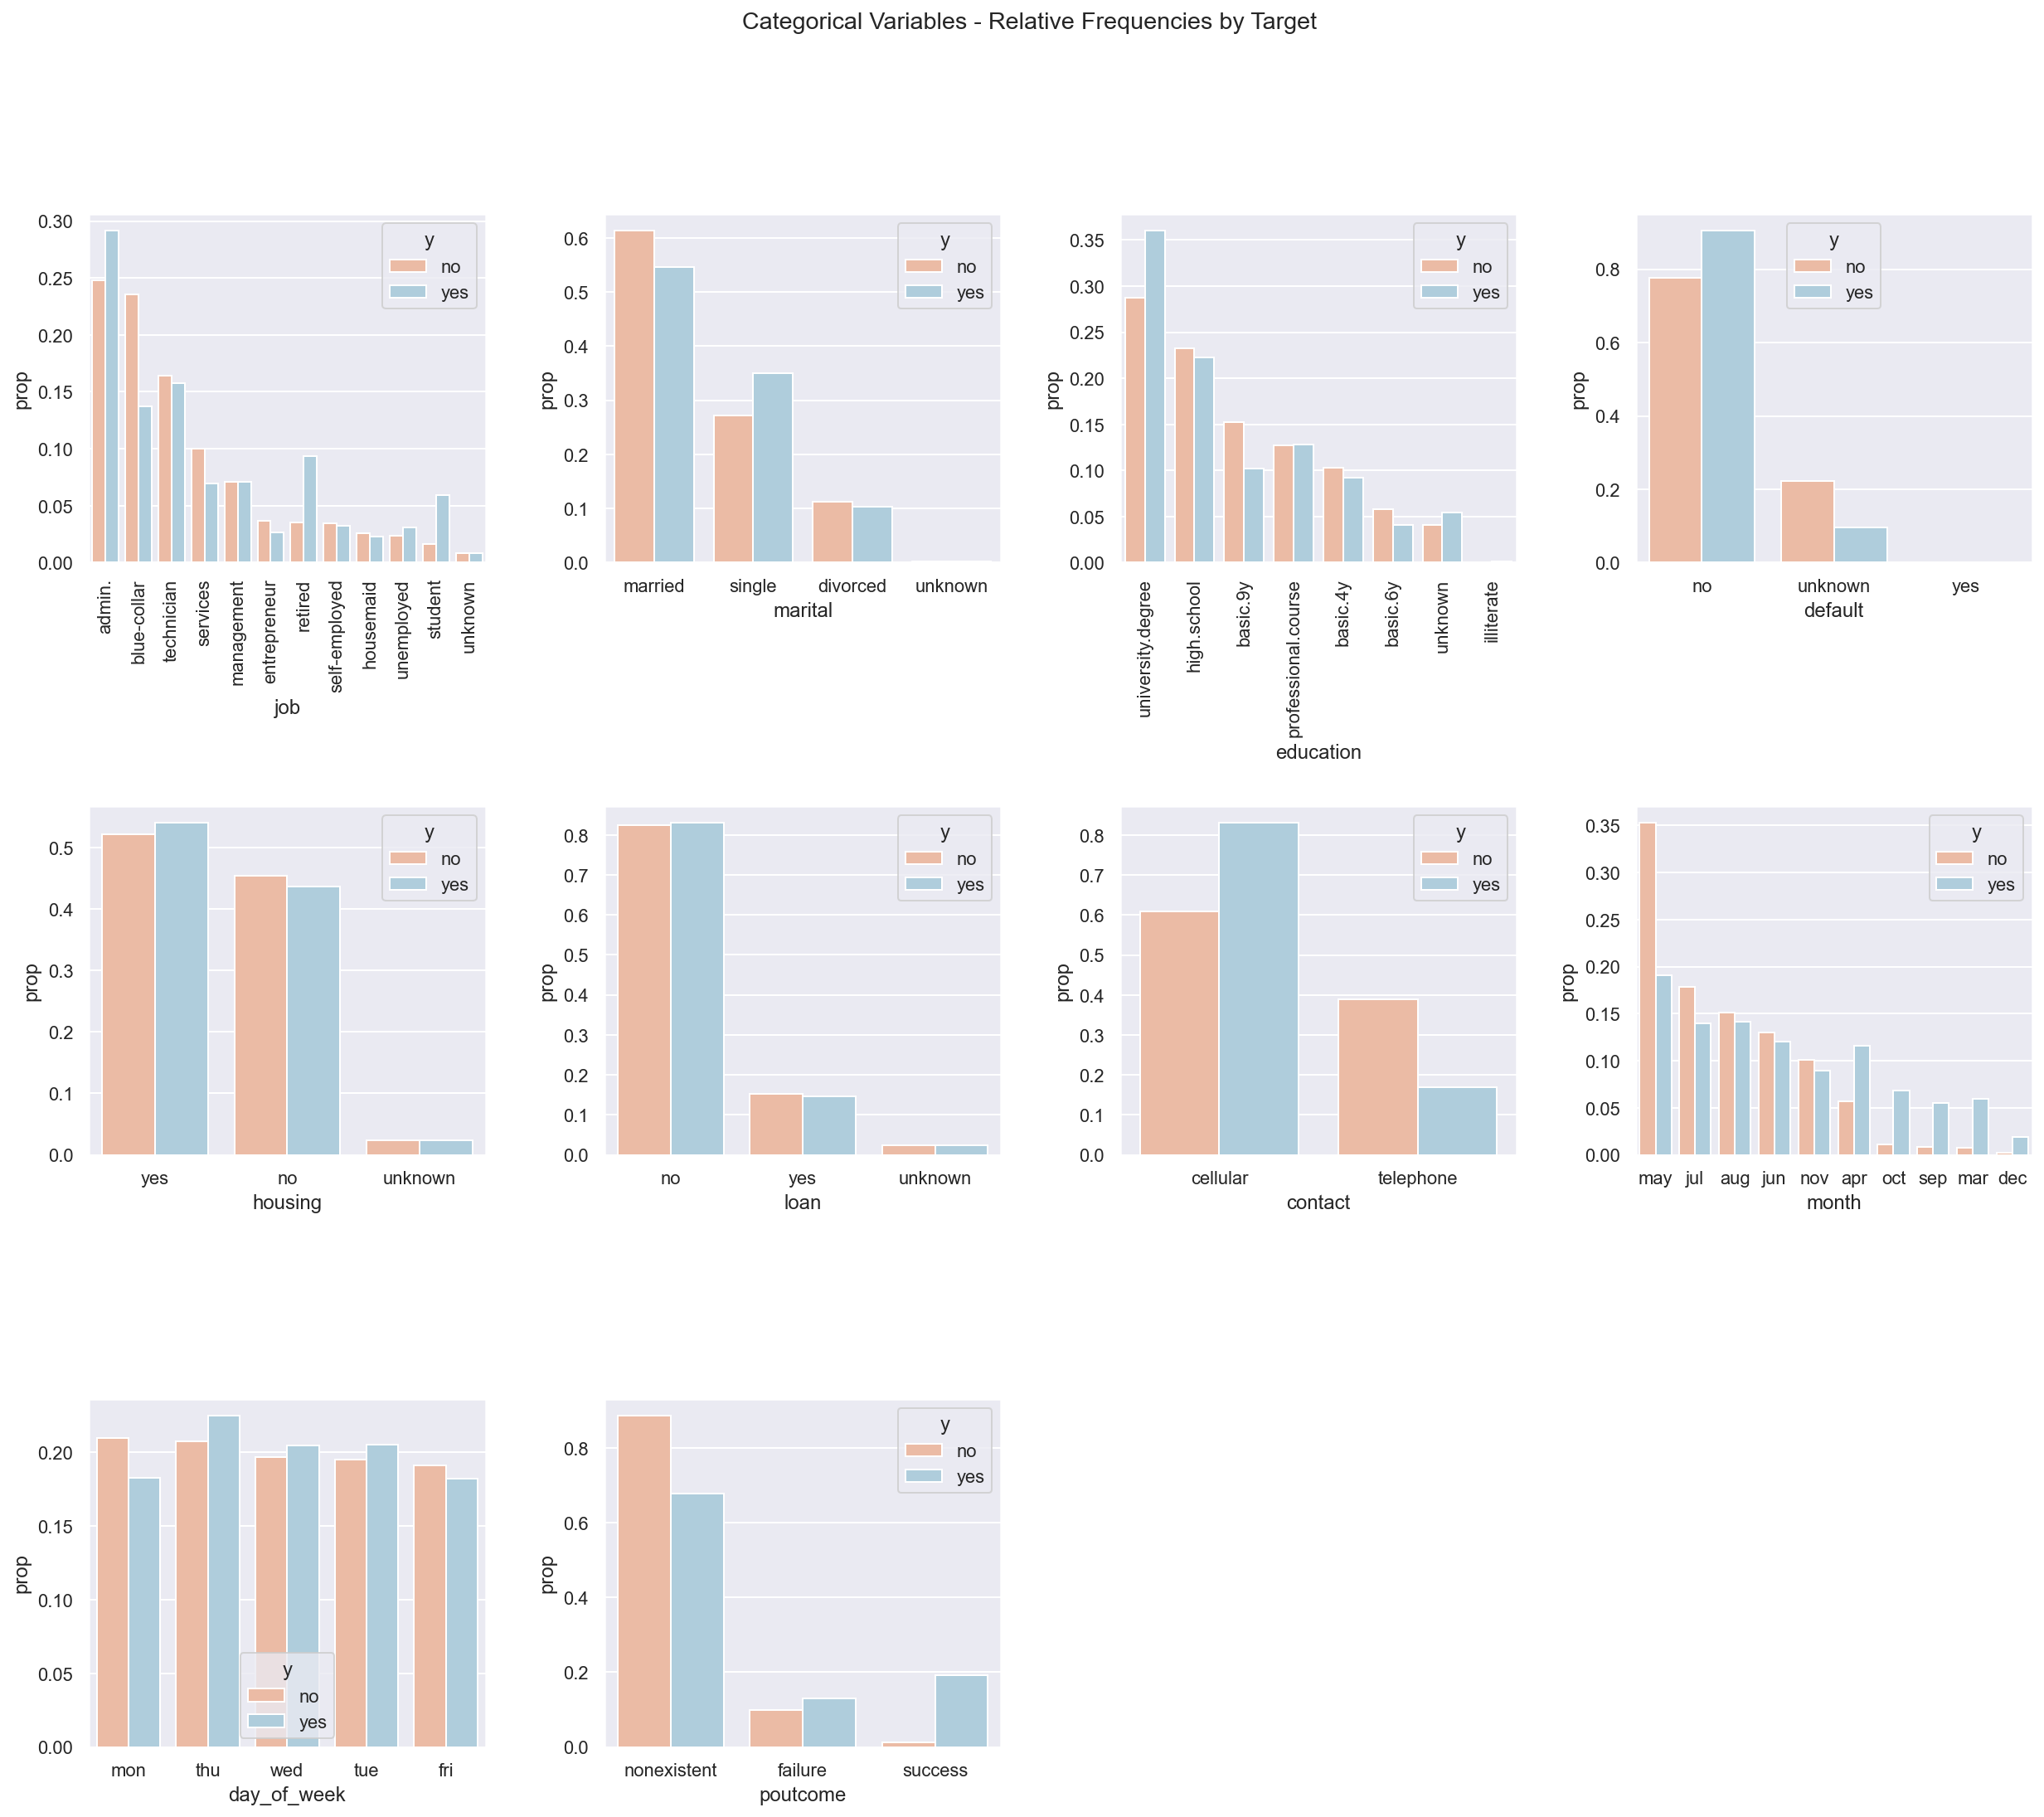

In [17]:
#Create visualizations separated by categorical target (ONLY WORK FOR CLASSIFICATION PROBLEMS -target values 0 or 1)
#Remove target value of non_metric_features
non_metric_features2 = non_metric_features.copy()
non_metric_features2.remove("y")

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(3, ceil(len(non_metric_features2) / 3), figsize=(21, 17))

# Plot data
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), non_metric_features2):
    data = df1.groupby(['y'])[feat].value_counts(normalize=True).rename('prop').reset_index()
    sns.barplot(data=data, x=feat, y='prop', hue='y', ax=ax, palette = "RdBu")

#Add a title to the plot
title = "Categorical Variables - Relative Frequencies by Target"
plt.suptitle(title)
#Adjust the rotation of xlabels
axes.flatten()[0].tick_params(axis='x', labelrotation = 90)
axes.flatten()[2].tick_params(axis='x', labelrotation = 90)

#Adjust the space between the plots
plt.subplots_adjust(wspace=0.3, hspace=0.7)

#Remove the last graphic
axes.flatten()[-1].remove()
axes.flatten()[-2].remove()
plt.show()

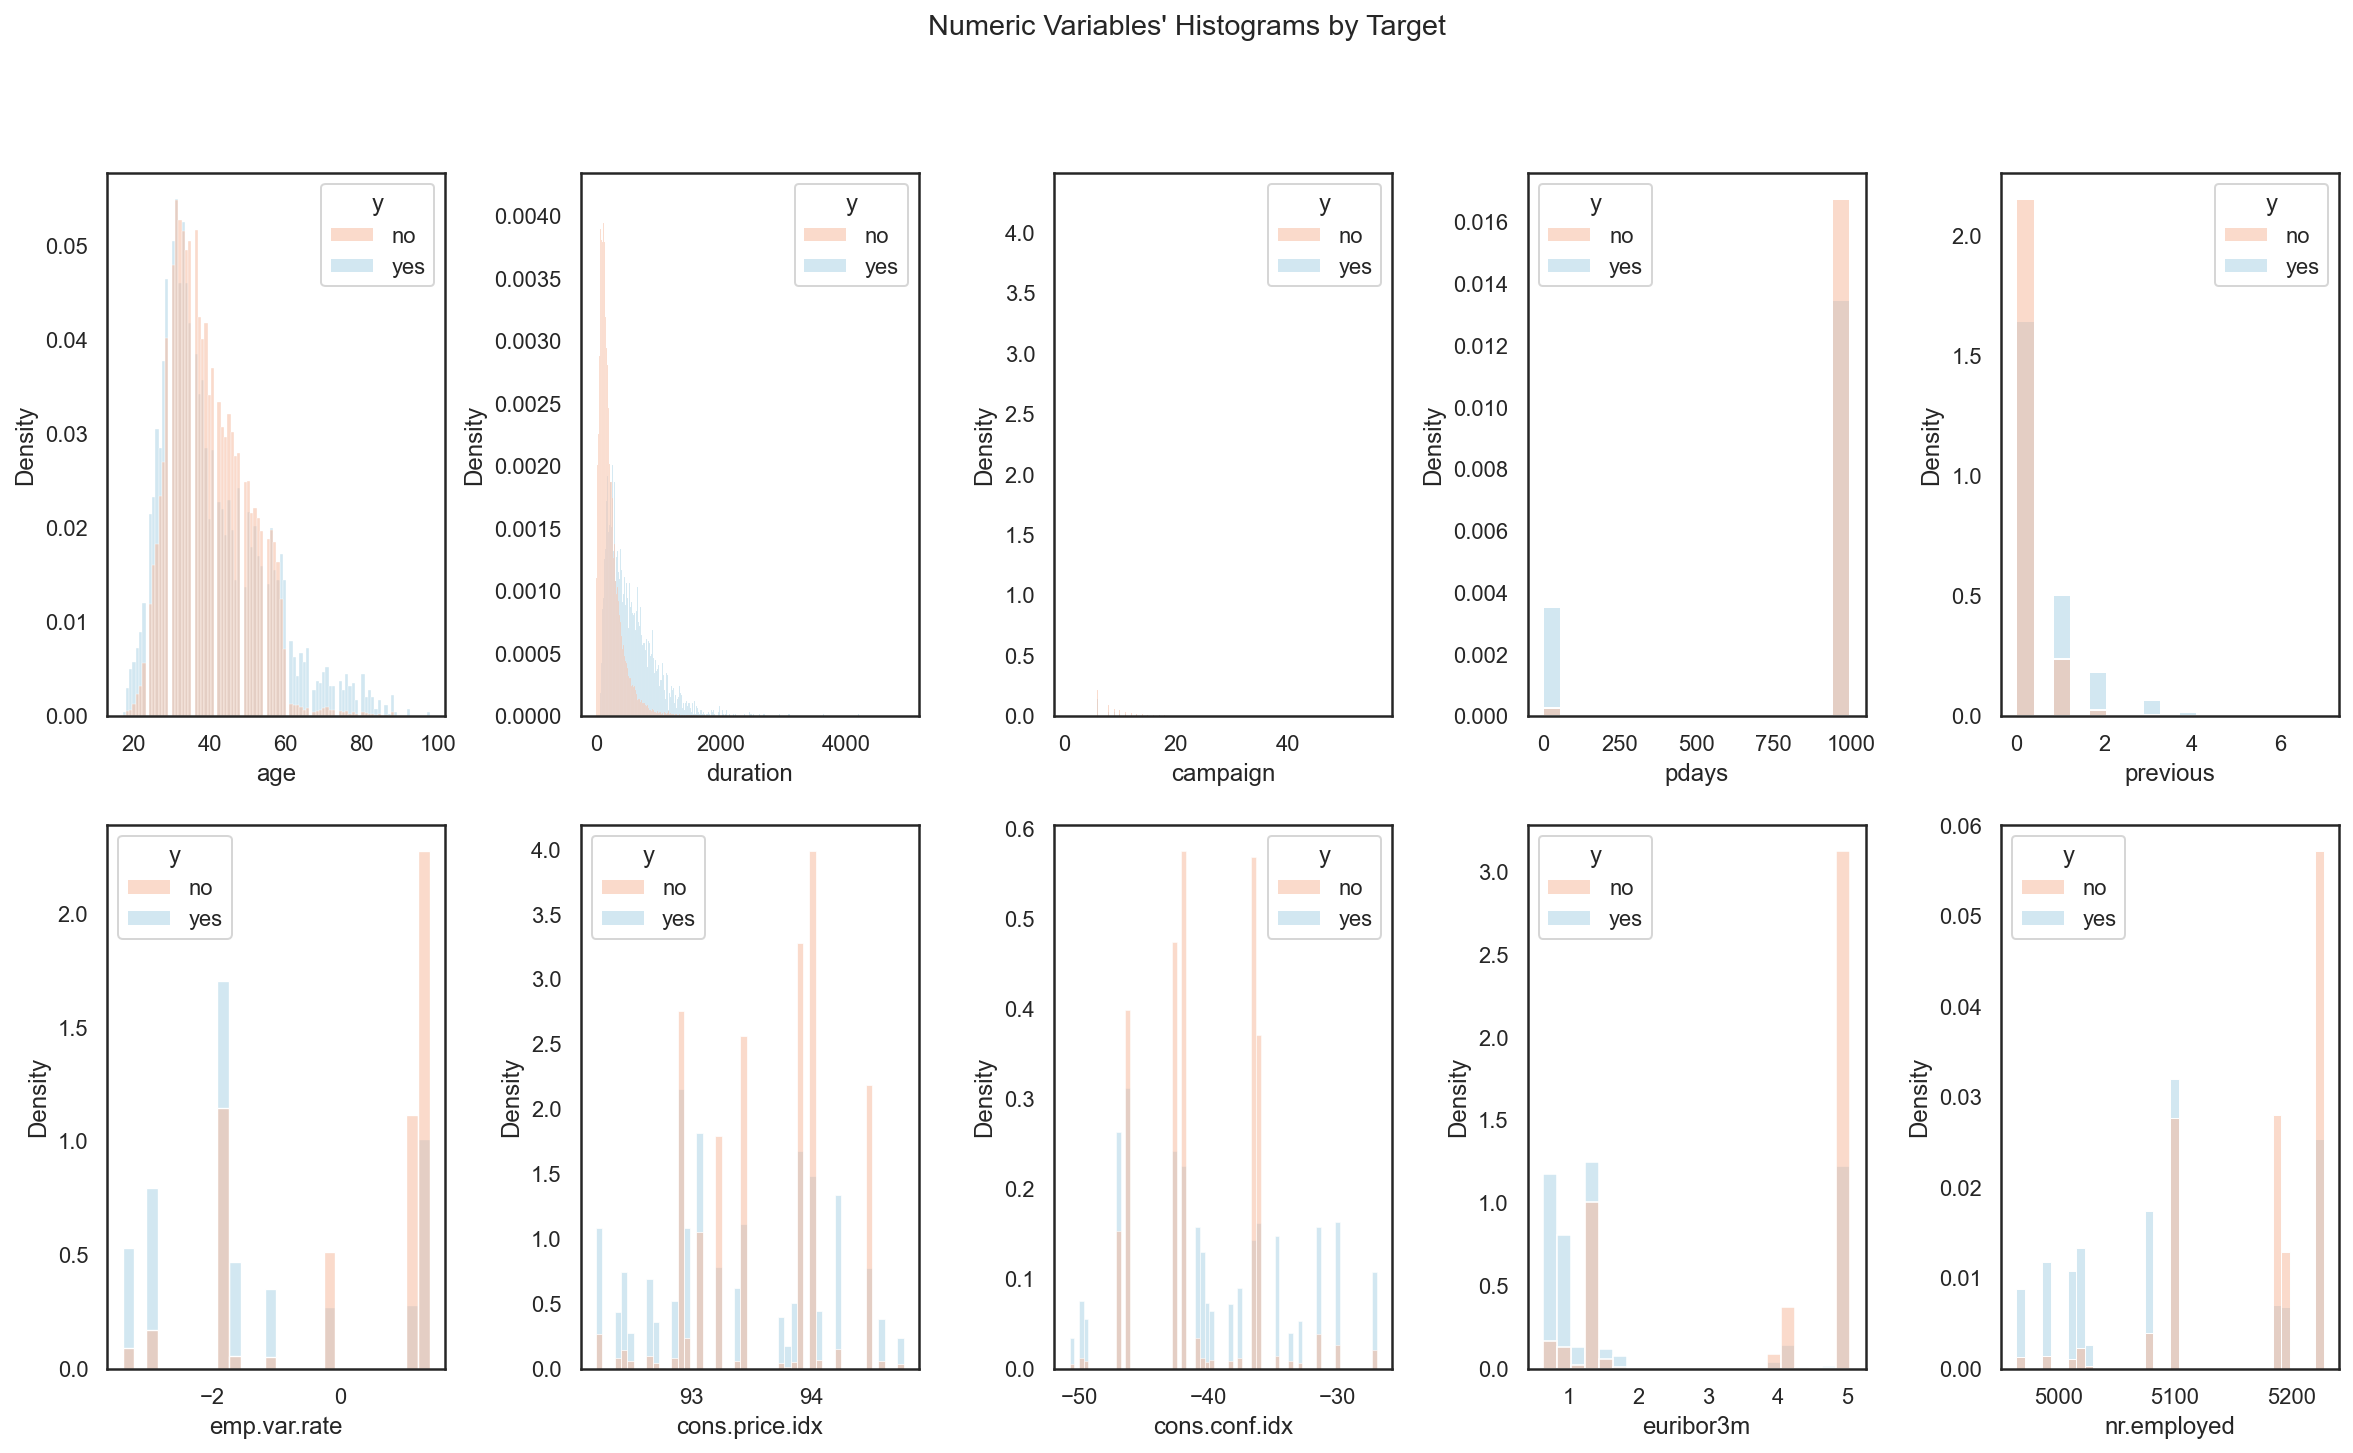

In [18]:
# All Numeric Variables Histograms separated by target
sns.set_style("white")
# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=df1[feat], hue=df1['y'], stat='density', common_norm=False, ax=ax, palette = "RdBu")
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms by Target"
plt.suptitle(title)
#Adjust the space between plots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [19]:
correlation = np.round(df1.corr(),2)
correlation

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp.var.rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons.price.idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons.conf.idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr.employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


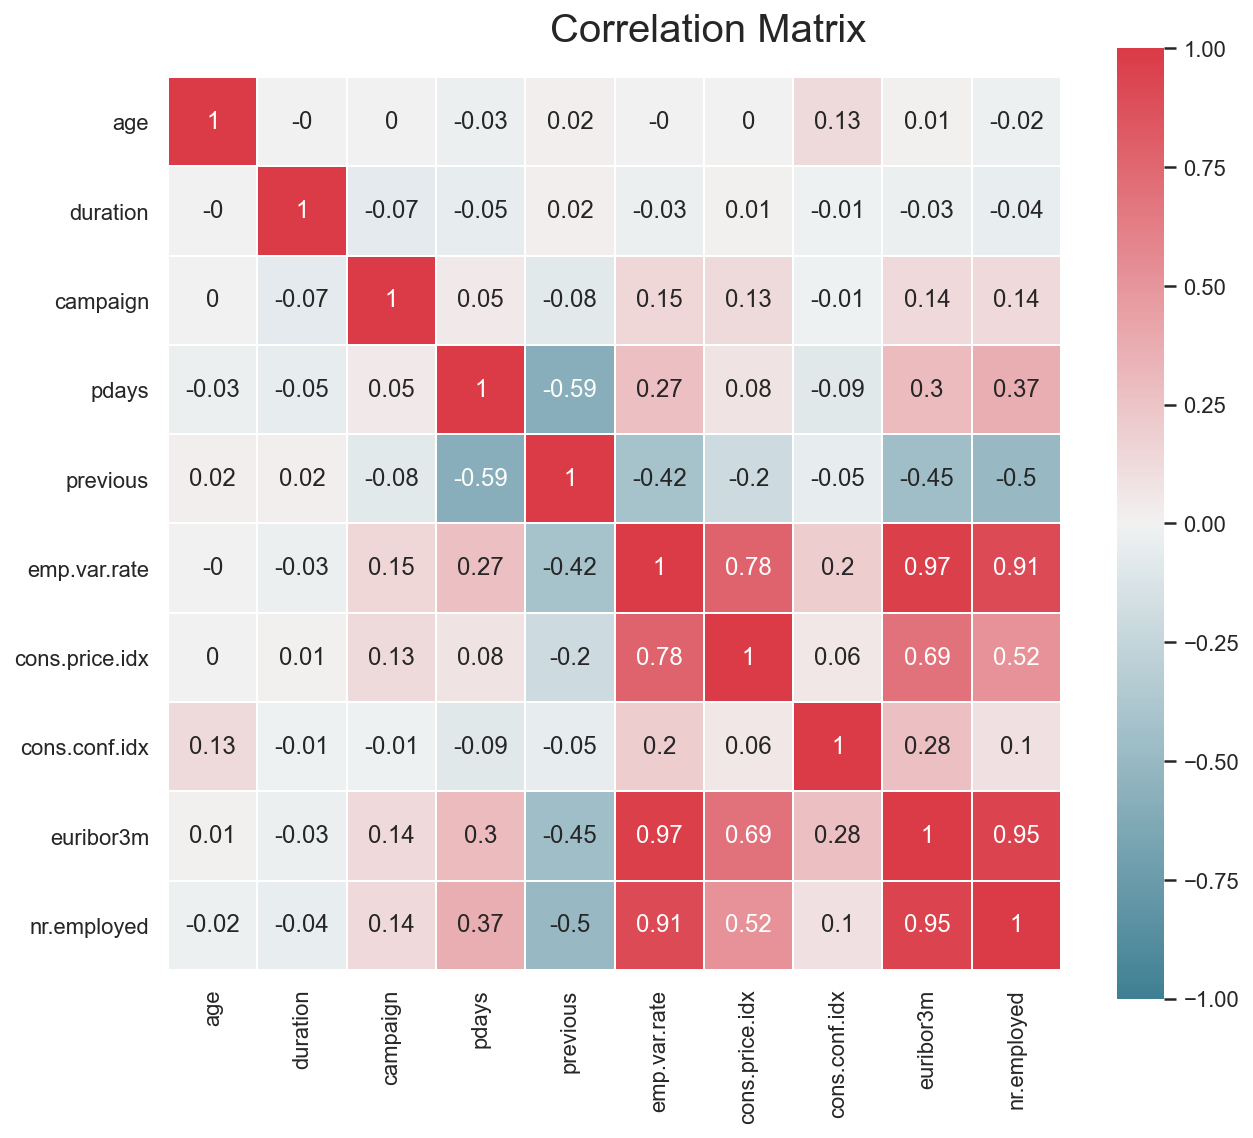

In [20]:
#Correlation matrix
fig = plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation, annot = correlation.values,cmap=sns.diverging_palette(220, 10, as_cmap=True), 
             vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [21]:
# Percentage of y='yes'(only for classification)
(df['y']=='yes').value_counts(normalize=True)

False    0.887346
True     0.112654
Name: y, dtype: float64

<AxesSubplot:xlabel='y', ylabel='count'>

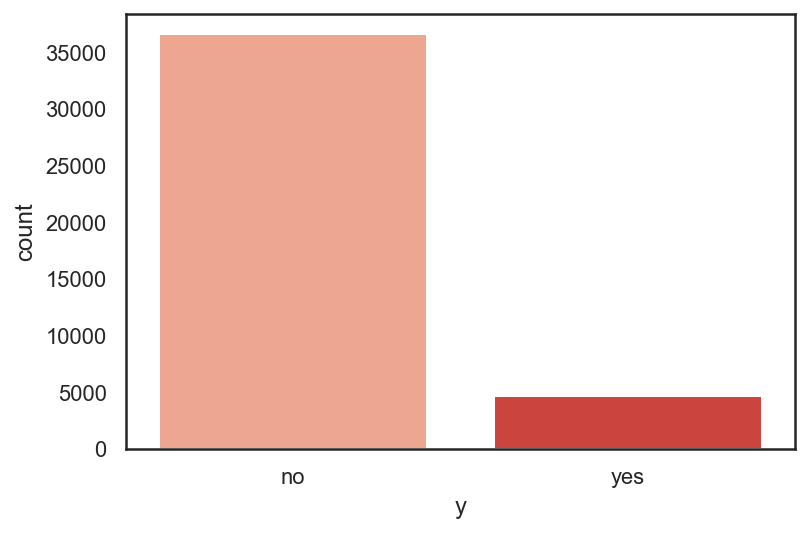

In [22]:
#Only for classification
sns.set_style('white')
sns.countplot(x='y',data= df1,palette = "Reds")

### Reduce sparsity

## CREATE MATRIX AND SPLIT DATA TRAIN AND TEST
